In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('Samsung_Dataset.csv')

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4449.709961,74195000
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4063.728760,74680000
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4092.859863,54390000
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4034.598877,40305000
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4202.098145,46880000


In [4]:
(data['Volume']==0).sum()

127

In [5]:
data = data[data.iloc[:, -1] != 0]

In [6]:
data.reset_index(inplace = True)

In [7]:
data.shape

(6000, 8)

In [8]:
data['Date'] = pd.to_datetime(data['Date'])
data.dtypes

index                 int64
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [9]:
data_pivot = data.pivot_table(index='Date', values=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], aggfunc='mean')
data_pivot.reset_index(inplace=True)
data_pivot.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2000-01-04,4449.709961,6110.0,6110.0,5660.0,6000.0,74195000
1,2000-01-05,4063.728760,5580.0,6060.0,5520.0,5800.0,74680000
2,2000-01-06,4092.859863,5620.0,5780.0,5580.0,5750.0,54390000
3,2000-01-07,4034.598877,5540.0,5670.0,5360.0,5560.0,40305000
4,2000-01-10,4202.098145,5770.0,5770.0,5580.0,5600.0,46880000


In [10]:
df = data_pivot

In [11]:
df['MA_20'] = df['Close'].rolling(window=20).mean()

In [12]:
df['MA_200'] = df['Close'].rolling(window=200).mean()

In [13]:
def RSI(df, period=14):
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    ema_gain = gain.ewm(com=period - 1, adjust=False).mean()
    ema_loss = loss.ewm(com=period - 1, adjust=False).mean()
    RS = ema_gain / ema_loss
    RSI = 100 - (100 / (1 + RS))
    return RSI

df['RSI_14'] = RSI(df, period=14)

In [14]:
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,MA_20,MA_200,RSI_14
0,2000-01-04,4449.709961,6110.0,6110.0,5660.0,6000.0,74195000,NaN,NaN,NaN
1,2000-01-05,4063.728760,5580.0,6060.0,5520.0,5800.0,74680000,NaN,NaN,0.000000
2,2000-01-06,4092.859863,5620.0,5780.0,5580.0,5750.0,54390000,NaN,NaN,7.516779
3,2000-01-07,4034.598877,5540.0,5670.0,5360.0,5560.0,40305000,NaN,NaN,6.469386
4,2000-01-10,4202.098145,5770.0,5770.0,5580.0,5600.0,46880000,NaN,NaN,34.658860


In [15]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
df['MA_20'] = imputer.fit_transform(df[['MA_20']])
df['MA_200'] = imputer.fit_transform(df[['MA_200']])
df['RSI_14'] = imputer.fit_transform(df[['RSI_14']])

In [16]:
lag = [1]
for value in lag:
    df[f'Close {value}'] = df['Close'].shift(value)
    df[f'Volume {value}'] = df['Volume'].shift(value)
    df[f'High {value}'] = df['High'].shift(value)
    df[f'Low {value}'] = df['Low'].shift(value)
    df[f'Adj Close {value}'] = df['Adj Close'].shift(value)
    df[f'Open {value}'] = df['Adj Close'].shift(value)
    df[f'MA_20 {value}'] = df['MA_20'].shift(value)
    df[f'MA_200 {value}'] = df['MA_200'].shift(value)
    df[f'RSI_14 {value}'] = df['RSI_14'].shift(value)

In [17]:
df.shape

(6000, 19)

In [18]:
df = df.fillna(0)

In [19]:
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,MA_20,MA_200,RSI_14,Close 1,Volume 1,High 1,Low 1,Adj Close 1,Open 1,MA_20 1,MA_200 1,RSI_14 1
0,2000-01-04,4449.709961,6110.0,6110.0,5660.0,6000.0,74195000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
1,2000-01-05,4063.728760,5580.0,6060.0,5520.0,5800.0,74680000,0.0,0.0,0.000000,6110.0,74195000.0,6110.0,5660.0,4449.709961,4449.709961,0.0,0.0,0.000000
2,2000-01-06,4092.859863,5620.0,5780.0,5580.0,5750.0,54390000,0.0,0.0,7.516779,5580.0,74680000.0,6060.0,5520.0,4063.728760,4063.728760,0.0,0.0,0.000000
3,2000-01-07,4034.598877,5540.0,5670.0,5360.0,5560.0,40305000,0.0,0.0,6.469386,5620.0,54390000.0,5780.0,5580.0,4092.859863,4092.859863,0.0,0.0,7.516779
4,2000-01-10,4202.098145,5770.0,5770.0,5580.0,5600.0,46880000,0.0,0.0,34.658860,5540.0,40305000.0,5670.0,5360.0,4034.598877,4034.598877,0.0,0.0,6.469386


In [20]:
# prompt: minmax scaler without Date columns

scaler = MinMaxScaler()
columns_to_scale =df.columns.drop('Date')
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [21]:
X = df.drop(columns =['Date','Adj Close','Close', 'High','Low','Volume','MA_20','MA_200','RSI_14'])
Y = df['Close']

In [22]:
X

,Open,Close 1,Volume 1,High 1,Low 1,Adj Close 1,Open 1,MA_20 1,MA_200 1,RSI_14 1
0,0.039426,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.037147,0.067143,0.451816,0.063120,0.063240,0.052165,0.052165,0.000000,0.000000,0.000000
2,0.036577,0.061319,0.454770,0.062603,0.061676,0.047640,0.047640,0.000000,0.000000,0.000000
3,0.034412,0.061758,0.331212,0.059711,0.062346,0.047982,0.047982,0.000000,0.000000,0.088957
4,0.034868,0.060879,0.245440,0.058574,0.059888,0.047299,0.047299,0.000000,0.000000,0.076562
...,...,...,...,...,...,...,...,...,...,...
5995,0.864403,0.850549,0.141144,0.805785,0.858101,0.907386,0.907386,0.892112,0.911609,0.599963
5996,0.838195,0.849451,0.129034,0.811983,0.861453,0.906213,0.906213,0.889805,0.912130,0.596005
5997,0.835916,0.831868,0.088900,0.791322,0.844693,0.887456,0.887456,0.887499,0.912607,0.535163
5998,0.829079,0.826374,0.103347,0.785124,0.839106,0.881594,0.881594,0.885192,0.913085,0.517389


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.2, shuffle = False)

In [24]:
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
X_train_reshaped = X_train_np.reshape((X_train_np.shape[0], 10,1))
X_test_reshaped = X_test_np.reshape((X_test_np.shape[0], 10,1))

In [25]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(10, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

C:\Users\OS\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

In [27]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=60, verbose=1)


Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0083 - val_loss: 0.0052
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3364e-04 - val_loss: 0.0028
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9585e-04 - val_loss: 6.5432e-04
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7959e-04 - val_loss: 7.3668e-04
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6523e-04 - val_loss: 3.7651e-04
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7227e-04 - val_loss: 3.9747e-04
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4413e-04 - val_loss: 4.3519e-04
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4472e-04 - val_loss: 4.3492e-04
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4067e-04 - val_loss: 4.6819e-04
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3688e-04 - val_loss: 4.6209e-04
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2462e-04 - val_loss

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0602e-05 - val_loss: 4.2944e-04
Epoch 66/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1730e-05 - val_loss: 2.9717e-04
Epoch 67/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4336e-05 - val_loss: 3.1694e-04
Epoch 68/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5992e-05 - val_loss: 7.1521e-04
Epoch 69/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0837e-05 - val_loss: 4.9917e-04
Epoch 70/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1257e-05 - val_loss: 2.8859e-04
Epoch 71/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3448e-05 - val_loss: 5.2577e-04
Epoch 72/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8141e-05 - val_loss: 3.1365e-04
Epoch 73/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7584e-05 - val_loss: 3.9202e-04
Epoch 74/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1219e-05 - val_loss: 4.4711e-04
Epoch 75/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1600e-05 - 

In [28]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,705 (373.85 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,804 (249.24 KB)

In [29]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [30]:
train_predict

array([[0.00057727],
       [0.03716201],
       [0.03350653],
       ...,
       [0.49940348],
       [0.49332488],
       [0.48353577]], dtype=float32)

In [31]:
train_mse =mean_squared_error(y_train, train_predict)
test_mse = mean_squared_error(y_test, test_predict)
print(f"Train MSE: {train_mse}, Test MSE: {test_mse}")

Train MSE: 2.7454516479003542e-05, Test MSE: 0.00030810362112654836


In [32]:
y_test.index = np.arange(1200)

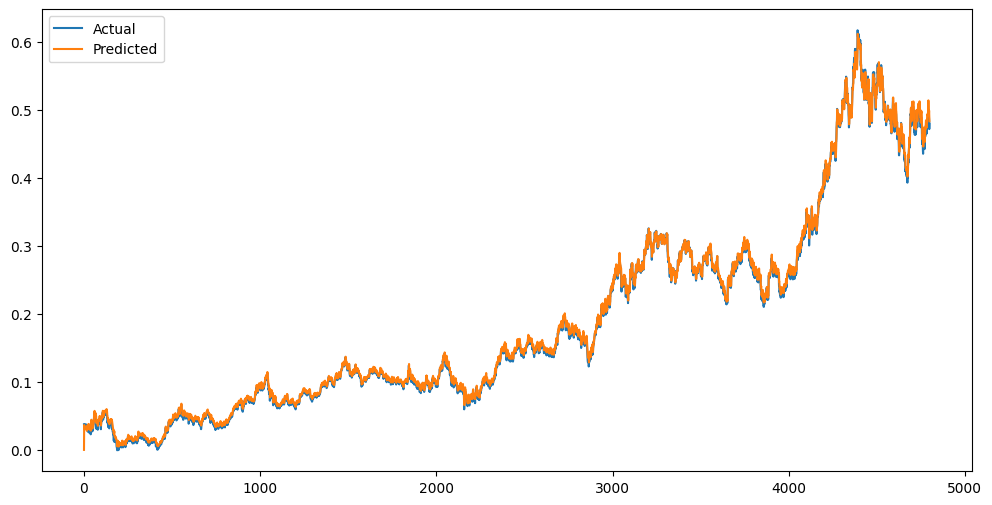

In [34]:
plt.figure(figsize=(12,6))
plt.plot(y_train, label='Actual')
plt.plot(train_predict, label='Predicted')
plt.legend()
plt.show()

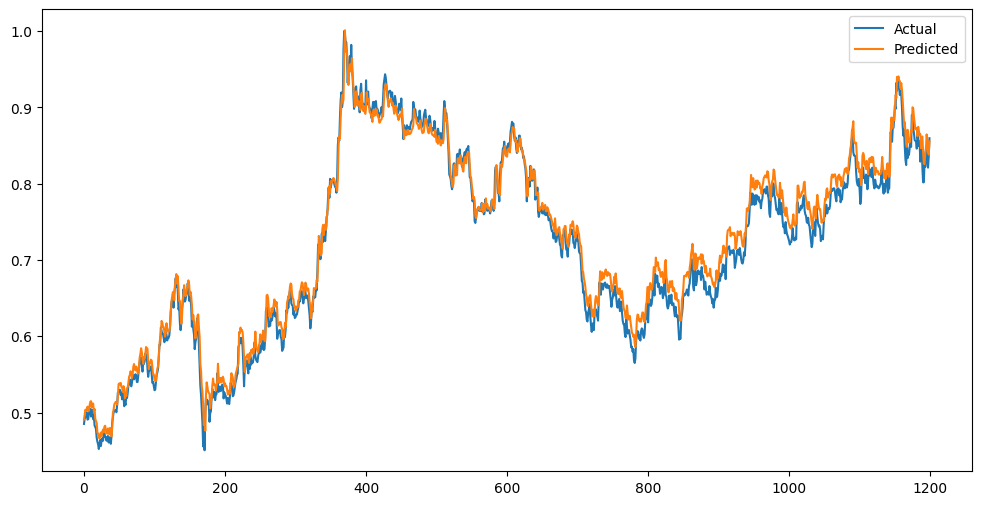

In [33]:
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual')
plt.plot(test_predict, label='Predicted')
plt.legend()
plt.show()